In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
import locale
locale.setlocale(locale.LC_TIME, "pt_PT") # processar datas em PT
import aosol.series.consumo as series
import aosol.series.producao as seriesprod
import aosol.series.pvgis as pvgis
import aosol.analise.analise_energia as ae
import aosol.analise.analise_financeira as af
import aosol.analise.analise_precos_energia as ape
from tabulate import tabulate

# Procura UPAC

Qual a UPAC que poderá permitir um menor custo de energia?

Estudo de diferentes tamanhos de UPAC e bateria e cálculo de indice de auto suficiência (IAS) e custo de energia.
O tamanho do sistema é definido pelos seguintes parâmetros:

$r_{pv} = \frac{Producao_{PV}}{Consumo} \left[ \frac{kWh}{kWh} \right]$

$r_{bat} = \frac{CAP_{bat}}{Consumo} \left[ \frac{kWh}{MWh} \right]$

Para perfil de consumo é usado o perfil de carga médio da e-redes ajustado para um valor de consumo anual enquanto o perfil de produção é obtido do PVGIS.

Inspirado no artigo:

S. Quoilin, K. Kavvadias, A. Mercier, I. Pappone, A. Zucker, 
Quantifying self-consumption linked to solar home battery systems: statistical analysis and economic assessment, 
Applied Energy, 2016

In [2]:
# =====================
# Consumo
# =====================
ano_consumo = 2023
perfil = 'BTN C' # ver na document
consumo_anual = 8400 # kWh, exemplo consumo médio 700 kWh/mes
fich_perfil_eredes = r"./consumo/perfis_eredes/E-REDES_Perfil_Consumo_2023.csv"

# =====================
# Producao
# =====================
ano_producao = 2023 # converter as datas de producao para este ano
# Opcoes API PVGIS
inicio_ano_pvgis = 2005
fim_ano_pvgis = 2023 # PVGIS-SARAH3 na V5.3 (2005-2023)
lat = 40.280  # Covilha
lon = -7.504
inclinacao = 30
azimute = 0.0 # azimute = 180 + x; 0 = Sul
perdas = 14 # %

# =====================
# Sistema
# =====================
params_sistema_sem_bateria = {
    "consumo_anual" : consumo_anual,
    "eficiencia_inversor" : 0.96
}

params_sistema_com_bateria = {
    "consumo_anual" : consumo_anual,
    "eficiencia_inversor" : 0.96,
    "eficiencia_bateria" : 0.92,
    "soc_min" : 0.1,
    "soc_max" : 0.9,
    "pot_maxima" : 5 # kW
}

# =====================
# Custos
# =====================
params_financeiros = {
    "tempo_vida": 20,
    "tempo_vida_bat": 10,
    "pv_por_kW": 1000,
    "bat_fixo": 700,          # Solax triple power master box
    "bat_euro_por_kWh": 450,  # Solax triple power bateria 3kWh ~1300€
    "perc_custo_manutencao": 0.5, # em %
    "taxa_actualizacao": 5,   # em %
    "simples_kWh": 0.1492,    # simples (gold energy)
    "vazio_kWh": 0.1001,      # bihorario (galp)
    "fora_vazio_kWh": 0.1751, # bihorario (galp)
    "preco_venda_rede": 0.04  # 4cent/kWh
}

# precos energia
preco_venda_rede= 0.04 # 4cent/kWh



## Consumo

In [3]:
perfil_eredes = series.leitura_perfis_eredes(fich_perfil_eredes, perfil)
consumo = series.ajustar_perfil_eredes_a_consumo_anual(perfil_eredes, consumo_anual, 'BTN C', 'consumo')

Consumo anual = 8400.0 kWh


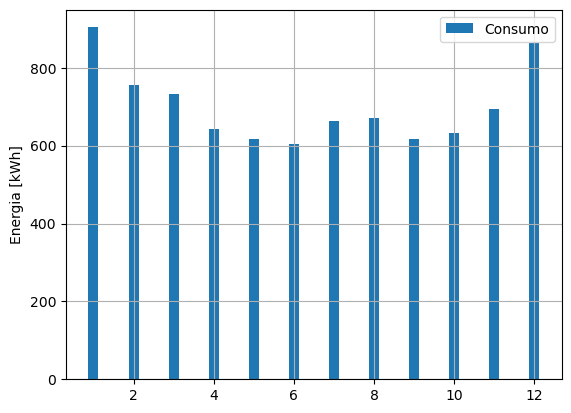

In [4]:
consumo_mensal = consumo['consumo'].resample('M').sum()

width = 0.25
plt.bar(consumo_mensal.index.month, consumo_mensal, width=width, label='Consumo')
plt.legend()
plt.ylabel('Energia [kWh]')
plt.grid()

print("Consumo anual = {:.1f} kWh".format(consumo['consumo'].sum()))

## Produção

Obter disponibilidae PV com sistema de 1kWp para a localização escolhida. Sistema virado a sul com inclinação 30º

Text(0.5, 1.0, 'Disponibilidade PV')

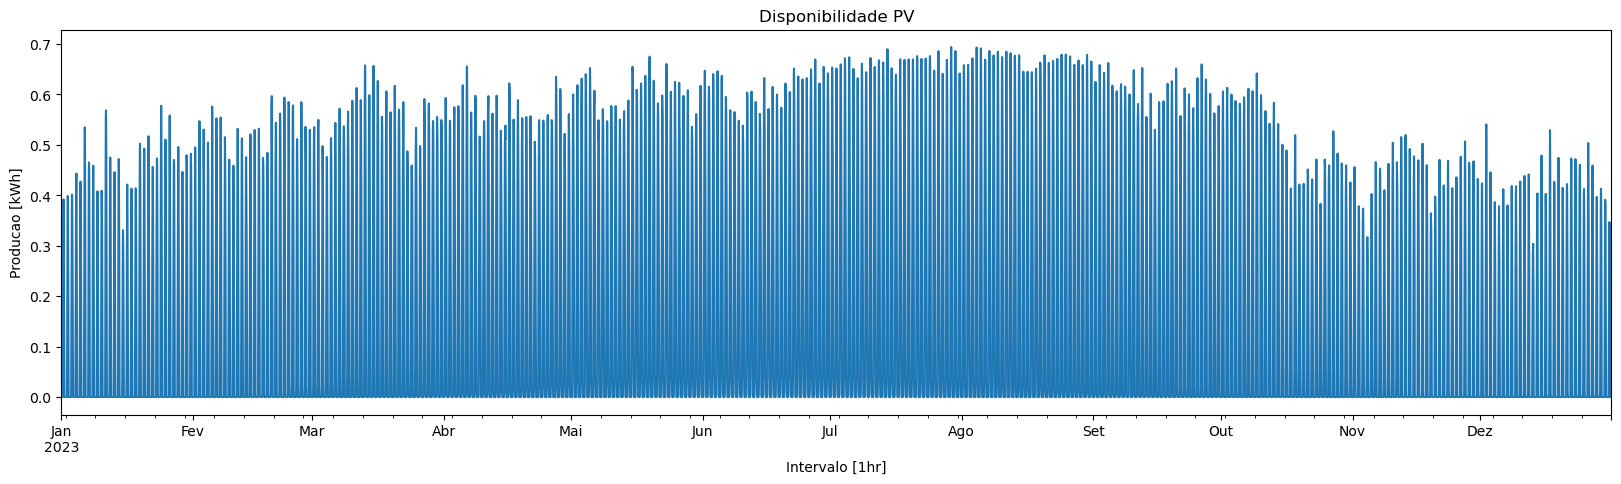

In [5]:
producao = pvgis.get_pvgis_hourly(lat, lon, inicio_ano_pvgis, fim_ano_pvgis, surface_tilt=inclinacao, surface_azimuth=azimute, peakpower=1, loss=perdas)
producao = seriesprod.converter_pvgis_multiyear_ts(producao, ano_producao)

p,ax = plt.subplots(1,1, figsize=(20,5))
producao["autoproducao"].plot(ax=ax)
plt.ylabel('Producao [kWh]')
plt.xlabel('Intervalo [1hr]')
plt.title('Disponibilidade PV')

In [6]:
print(f"Disponibilidade PV = {producao['autoproducao'].mean()*8760:.0f} kWh/kWp")

Disponibilidade PV = 1440 kWh/kWp


## Estudo de UPAC sem bateria

Estudo de sistema com $0 \leq r_{PV} \leq 3$. Desde sem instalação de PV até sistema que produz 3x o consumo anual.

Tarifario simples:
Custo energia sem PV = 0.1492 €/kWh
Sem venda rede: 2.4 kWp com custo energia = 0.12 €/kWh para IAS = 34.9 %
Com venda rede: 3.0 kWp com custo energia = 0.12 €/kWh para IAS = 37.7 %
Tarifario bihorario:
Custo energia sem PV = 0.1501 €/kWh
Sem venda rede: 2.4 kWp com custo energia = 0.11 €/kWh para IAS = 34.9 %
Com venda rede: 3.6 kWp com custo energia = 0.11 €/kWh para IAS = 39.4 %


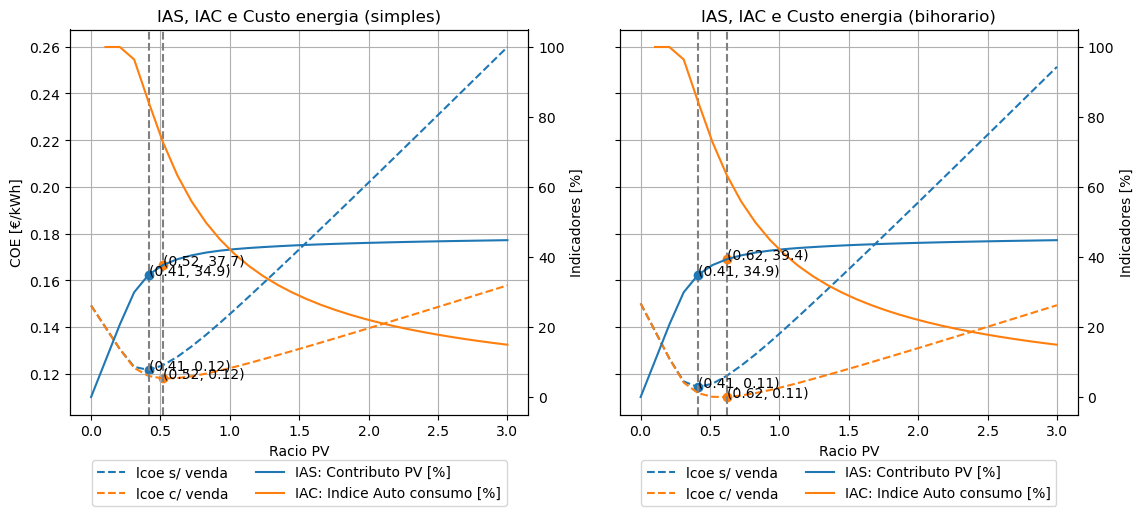

In [7]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

results_simples, c = ae.estudo_upac_sem_bateria(consumo, producao, params_sistema_sem_bateria, ape.Tarifario.Simples, params_financeiros)
print("Tarifario simples:")
print(f"Custo energia sem PV = {c:.4f} €/kWh")
ae.plot_estudo_sem_bateria(results_simples, ax[0], "IAS, IAC e Custo energia (simples)")

results_bihorario, cb = ae.estudo_upac_sem_bateria(consumo, producao, params_sistema_sem_bateria, ape.Tarifario.Bihorario, params_financeiros)
print("Tarifario bihorario:")
print(f"Custo energia sem PV = {cb:.4f} €/kWh")
ae.plot_estudo_sem_bateria(results_bihorario, ax[1], "IAS, IAC e Custo energia (bihorario)")


## Estudo sistema com bateria

Sistema com $0.5 \leq r_{PV} \leq 2.5$ e $0 \leq r_{bat} \leq 2$

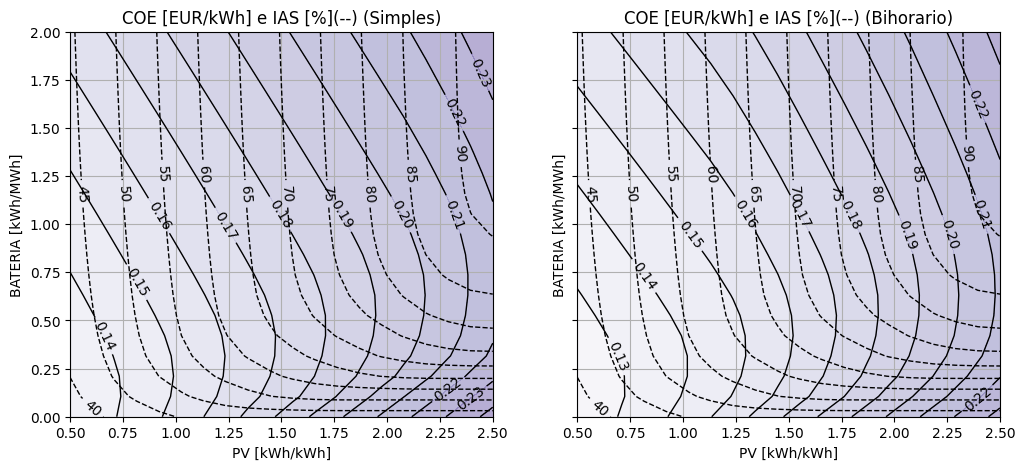

In [8]:
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

results_bat_simples = ae.estudo_upac_com_bateria(consumo, producao, params_sistema_com_bateria, ape.Tarifario.Simples, params_financeiros)
ae.plot_estudo_com_bateria(results_bat_simples, True, ax[0], 'COE [EUR/kWh] e IAS [%](--) (Simples)')

results_bat_bihorario = ae.estudo_upac_com_bateria(consumo, producao, params_sistema_com_bateria, ape.Tarifario.Bihorario, params_financeiros)
ae.plot_estudo_com_bateria(results_bat_bihorario, True, ax[1], 'COE [EUR/kWh] e IAS [%](--) (Bihorario)')

In [9]:
limite_lcoe = 0.14
limite_ias = 50

x = results_bat_bihorario.loc[(results_bat_bihorario["lcoe c/ venda"] < limite_lcoe) & (results_bat_bihorario["IAS: Contributo PV [%]"] > limite_ias)]
print(tabulate(x[["Potencia instalada [kW]", "Capacidade bateria [kWh]", "IAS: Contributo PV [%]", "lcoe c/ venda", "lcos c/ venda"]].sort_values("lcoe c/ venda"),
               headers=["Potencia instalada [kW]", "Capacidade bateria [kWh]", "IAS: Contributo PV [%]", "LCOE [€/kWh]", "LCOS [€/kWh]"],
               floatfmt=('.1f','.1f', '.1f', '.1f', '.4f', '.4f')))

               Potencia instalada [kW]    Capacidade bateria [kWh]    IAS: Contributo PV [%]    LCOE [€/kWh]    LCOS [€/kWh]
-----------  -------------------------  --------------------------  ------------------------  --------------  --------------
indicadores                        4.1                         3.5                      50.0          0.1365          0.3616
indicadores                        6.0                         2.7                      50.2          0.1365          0.3655
indicadores                        4.8                         3.5                      51.5          0.1368          0.3418
indicadores                        5.4                         3.5                      52.4          0.1379          0.3342
indicadores                        6.6                         2.7                      50.6          0.1382          0.3651
indicadores                        6.0                         3.5                      52.9          0.1395          0.3323
